
# Project 1: Digit Classification with KNN

# Intro
---
In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more.
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b> To be safe, please credit any sources used.


## Grading
---
 - Make sure to answer every part in every question.
 - There are 5 questions, each worth an equal number of points.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean or is not well commented
   - the functions or answers are excessively long

## Requirements:
---
1. Comment your code.
1. Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning, keep things inside functions).

## Additional reading and notes
---

If you are looking to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

Additionally, if you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'1.2.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.iloc[shuffle], Y.iloc[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:100: UserWarning: A network error occurred while downloading https://openml.org/api/v1/json/data/qualities/554. Retrying...
  warn(


data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Visualize a select sample of images
---
Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* Make the digits nice and big.
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

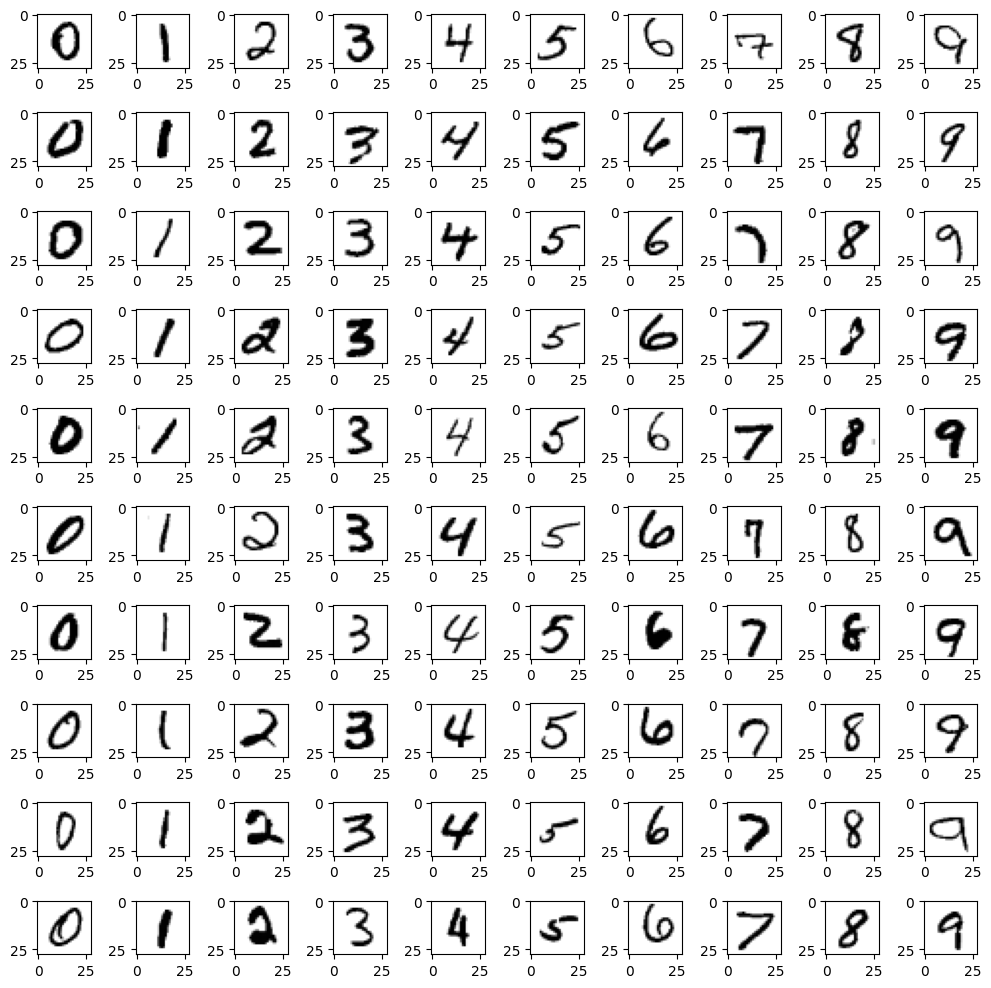

In [4]:
def Q1(num_examples=10):

  ### STUDENT START ###

  # Set the colormap for images to black and white
  plt.rc('image', cmap='binary')

  # Load the MNIST dataset
  images= train_data.values
  labels = train_labels.values

  # Define the number of digits per row and column for the plot
  digits_per_row = 10
  digits_per_col = 10

  # Function to reshape a 1D image array into a 2D array (28x28 pixels)
  def reshape_image(image):
    return image.reshape(28, 28)

  # Dictionary to hold 10 examples of each digit (0-9)
  digit_examples = {}
  for digit in range(10):
    # Select the first 10 examples of the current digit
    digit_examples[digit] = images[labels == str(digit)][0:10]

  # Create a figure with a grid of subplots (10x10)
  fig, axes = plt.subplots(digits_per_row, digits_per_col, figsize=(10, 10))

  # Iterate over each subplot position
  for i in range(digits_per_col):
    for j in range(digits_per_row):
      # Determine which digit to plot in the current position
      digit = j
      # Get the corresponding example image and reshape it to 28x28
      image = reshape_image(digit_examples[digit][i])
      # Display the image in the current subplot
      axes[i, j].imshow(image)

  # Adjust the layout to minimize overlap and display the plot
  plt.tight_layout()
  plt.show()

  ### STUDENT END ###

# Call the function to generate and show the plot with 10 examples per digit

Q1(10)

### Question 2: Evaluating different choices of k
---

1. Produce k-Nearest Neighbors models with k = 1, 3, 5, 7, and 9.  
1. Print the accuracy of each model.
1. Additionally, only for the 1-Nearest Neighbor model, show the precision, recall, and F1 for each label.
1. Which digit is the most *difficult* for the 1-Nearest Neighbor model to classify correctly? How did you choose and why?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Print only the information asked so it is easy to read and compare.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.
* Check out what the function "score" does.

In [5]:
def Q2(k_values):

  ### STUDENT START ###

  # Define values of k to be used
  k_values = [1, 3, 5, 7, 9]

  #1 For-loop through the 5 values of k
  for k in k_values:
      #2 Build and train the k-NN model
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(mini_train_data, mini_train_labels)

      # Evaluate accuracy on the dev set
      accuracy = knn.score(dev_data, dev_labels)
      print(f'k={k}, accuracy={accuracy:.4f}')

      #3 If k=1, print the classification report
      if k == 1:
          dev_predictions = knn.predict(dev_data)
          report = classification_report(dev_labels, dev_predictions, output_dict=True)
          print("Classification report for k=1:")
          print(classification_report(dev_labels, dev_predictions))

          # Find the most difficult digit to classify correctly
          f1_scores = {label: report[label]['f1-score'] for label in report if label.isdigit()}
          most_difficult_digit = min(f1_scores, key=f1_scores.get)
          print(f'The most difficult digit to classify correctly for k=1 is: {most_difficult_digit}')

  ### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
Q2(k_values)

k=1, accuracy=0.8840
Classification report for k=1:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

The most difficult digit to classify correctly for k=1 is: 8
k=3, accuracy=0.8760
k=5, accuracy=0.8820
k=7, accuracy=0.8770
k=9, accuracy=0.8750


Answer to Question 2: The most difficult digit to classify correctly for k=1 is: 8

### Question 3: Examining the importance of training size
---
1. Produce 1-Nearest Neighbor models using training data of various sizes. For example, ```train_data[:train_size]```.
1. Evaluate and show the accuracy achieved by each model.  
1. Show the time needed to:
  1. Train each model.
  1. Measure the accuracy of each model.
1. What do you see? Is this what you expected to see and why?
1. Plot on the same graph (as a function of training size):
  1. the time needed for training
  1. the time needed for calculating accuracy

Notes:
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

Training size: 100, Accuracy: 0.7020, Training time: 0.0444s, Accuracy time: 0.1337s
Training size: 200, Accuracy: 0.7910, Training time: 0.0472s, Accuracy time: 0.2145s
Training size: 400, Accuracy: 0.8110, Training time: 0.0436s, Accuracy time: 0.1236s
Training size: 800, Accuracy: 0.8660, Training time: 0.0287s, Accuracy time: 0.1204s
Training size: 1600, Accuracy: 0.9050, Training time: 0.0347s, Accuracy time: 0.1667s
Training size: 3200, Accuracy: 0.9270, Training time: 0.0463s, Accuracy time: 0.2639s
Training size: 6400, Accuracy: 0.9390, Training time: 0.0846s, Accuracy time: 0.4491s
Training size: 12800, Accuracy: 0.9520, Training time: 0.1309s, Accuracy time: 0.8035s
Training size: 25600, Accuracy: 0.9630, Training time: 0.2429s, Accuracy time: 1.4768s


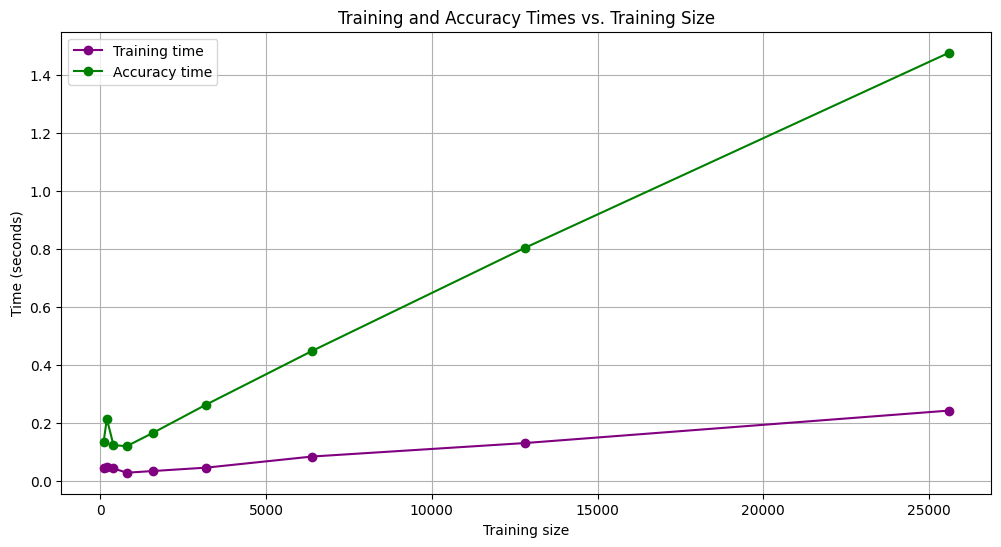

In [6]:
def Q3(train_sizes, accuracies_list, train_times_list, eval_times_list):

    ### STUDENT START ###

    # Lists to store times and accuracies
    train_times = []
    accuracy_times = []
    accuracies = []

    # Loop through different training sizes
    for size in train_sizes:
        # Create and train the 1-NN model
        knn = KNeighborsClassifier(n_neighbors=1)

        # Measure training time
        start_train_time = time.time()
        knn.fit(train_data[:size], train_labels[:size])
        end_train_time = time.time()
        train_times.append(end_train_time - start_train_time)

        # Measure accuracy time
        start_accuracy_time = time.time()
        accuracy = knn.score(dev_data, dev_labels)
        end_accuracy_time = time.time()
        accuracy_times.append(end_accuracy_time - start_accuracy_time)

        # Store accuracy
        accuracies.append(accuracy)

        # Print results for this training size
        print(f'Training size: {size}, Accuracy: {accuracy:.4f}, Training time: {train_times[-1]:.4f}s, Accuracy time: {accuracy_times[-1]:.4f}s')

    # Plot training and accuracy times
    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_times, label='Training time', marker='o', linestyle='-', color='purple')
    plt.plot(train_sizes, accuracy_times, label='Accuracy time', marker='o', linestyle='-', color='green')
    plt.xlabel('Training size')
    plt.ylabel('Time (seconds)')
    plt.title('Training and Accuracy Times vs. Training Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Append results to the provided lists
    accuracies_list.extend(accuracies)
    train_times_list.extend(train_times)
    eval_times_list.extend(accuracy_times)

    ### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
train_times = []
eval_times = []
Q3(train_sizes, accuracies, train_times, eval_times)

Answer to Question 3:

- Training size: 100, Accuracy: 0.7020, Training time: 0.0264s, Accuracy time: 0.0943s
- Training size: 200, Accuracy: 0.7910, Training time: 0.0252s, Accuracy time: 0.0883s
- Training size: 400, Accuracy: 0.8110, Training time: 0.0263s, Accuracy time: 0.1146s
- Training size: 800, Accuracy: 0.8660, Training time: 0.0260s, Accuracy time: 0.1114s
- Training size: 1600, Accuracy: 0.9050, Training time: 0.0327s, Accuracy time: 0.1581s
- Training size: 3200, Accuracy: 0.9270, Training time: 0.0413s, Accuracy time: 0.2944s
- Training size: 6400, Accuracy: 0.9390, Training time: 0.0902s, Accuracy time: 0.4009s
- Training size: 12800, Accuracy: 0.9520, Training time: 0.1508s, Accuracy time: 0.7418s
- Training size: 25600, Accuracy: 0.9630, Training time: 0.3042s, Accuracy time: 1.3752s

### Question 4: Evaluating if we should obtain additional data
---

In this question we wish to predict what accuracy we would get if we had additional training data.

Our input, our features and labels, are the output from the previous question. Based on the training size and accuracy we got in the previous question, we wish to predict the accuracy we would get if we had larger training sizes.

1. Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size.
1. Print $R^2$ of the linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot on a lineplot graph:
  1. the actual accuracies we obtained in the previous question
  1. and the accuracies our model predicted we would have gotten.
  1. The X axis is the training set size.
  1. You can limit the range of X and Y to the range where you have data for both plots. Meaning, in the this question, we want to visualize how good the prediction is.
1. What are two things that are wrong with our model?
1. Apply a transformation to the predictor features and a transformation to the outcome that make the predictions fix these issues.
1. Show $R^2$ of the improved linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot a lineplot graph of both again as before.
  1. Be sure to plot this where the Y axis is accuracy and X axis is training set size, **not the transformed space**!
  1. Choose the range of X and Y to visualize effectively.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hints:
  1. You have two problems here, how well your model fits and predicting *illogical* values of accuracy.
  1. You can look at:
    1. [logit](https://en.wikipedia.org/wiki/Logit): $\frac{1}{1 + e^{-x}} = \frac{e^x}{1+e^x}$ which takes numbers in $\[\infty,-\infty\]$ and outputs numbers in $(0, 1)$.
    1. [logistic](https://en.wikipedia.org/wiki/Logistic_function): $log(\frac{p}{1 - p})$ which takes numbers between $(0, 1)$ and outputs numbers between $\[\infty,-\infty\]$.
    1. It also happens that $x = logistic(p)$ is the same thing as $logit(x)=p$.

R^2 of the linear regression model: 0.4177
Predicted accuracies for additional training set sizes:
Training size: 60000, Predicted accuracy: 1.2362
Training size: 120000, Predicted accuracy: 1.6374
Training size: 1000000, Predicted accuracy: 7.5225


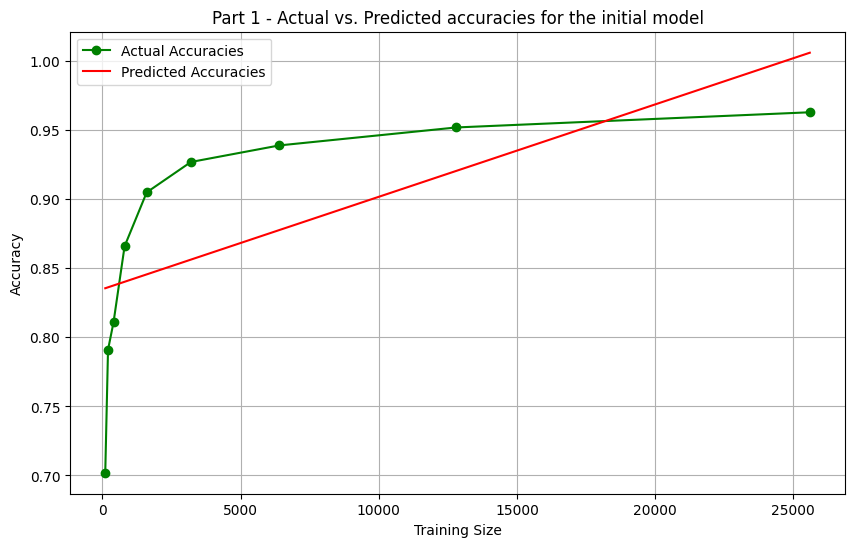

R^2 of the linear regression model: 0.9897
Predicted accuracies for additional training set sizes:
Training size: 60000, Predicted accuracy: 25691.4685
Training size: 120000, Predicted accuracy: 51383.9534
Training size: 1000000, Predicted accuracy: 428207.0641


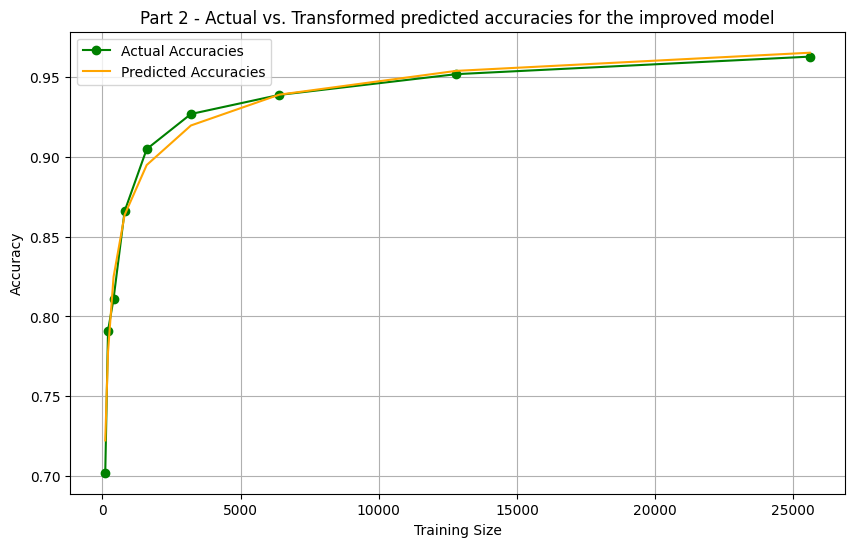

In [7]:
def Q4():

    ### STUDENT START ###

    # Part 1
    # Reshape train_sizes for compatibility with sklearn
    X = np.array(train_sizes).reshape(-1, 1)
    Y = accuracies

    # Initialize linear regression model
    lr = LinearRegression()

    # Fit the linear regression model
    lr.fit(X, Y)

    # Calculate R^2 of the linear regression model
    r_squared = lr.score(X, Y)
    print(f'R^2 of the linear regression model: {r_squared:.4f}')

    # Predict accuracies for additional training set sizes
    additional_sizes = np.array([60000, 120000, 1000000]).reshape(-1, 1)
    predicted_accuracies = lr.predict(additional_sizes)
    print(f'Predicted accuracies for additional training set sizes:')
    for size, accuracy in zip(additional_sizes.flatten(), predicted_accuracies):
      print(f'Training size: {size}, Predicted accuracy: {accuracy:.4f}')

    # Plot actual accuracies vs. predicted accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(X, Y, label='Actual Accuracies', marker='o', linestyle='-', color='green')
    plt.plot(X, lr.predict(X), label='Predicted Accuracies', linestyle='-', color='red')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Part 1 - Actual vs. Predicted accuracies for the initial model')
    plt.legend()
    plt.grid(True)
    plt.show()

    ### Part 2 ###

    # Transform accuracies using logistic function (0, 1 -> -inf, inf)
    # This improves linear regression performance by linearizing the data.
    logistic_accuracies = [np.log(p/(1-p)) for p in accuracies]

    # Apply logarithmic transformation to training sizes
    log_train_sizes = [np.log(t) for t in train_sizes]

    # Convert and reshape training sizes to a 2D array for sklearn
    X = np.array(log_train_sizes).reshape(-1, 1)

    # Set logistic accuracies as target variable
    Y = logistic_accuracies

    # Initialize linear regression model
    lr = LinearRegression()

    # Fit the linear regression model
    lr.fit(X, Y)

    # Calculate R^2 of the linear regression model (to measure model fit)
    r_squared = lr.score(X, Y)
    print(f'R^2 of the linear regression model: {r_squared:.4f}')

    # Transform predicted values back to the original scale using the logistic function
    y_pred = [np.exp(y)/(np.exp(y)+ 1) for y in lr.predict(X)]

    # Predict accuracies for additional training set sizes
    additional_sizes = np.array([60000, 120000, 1000000]).reshape(-1, 1)
    predicted_accuracies = lr.predict(additional_sizes)
    print(f'Predicted accuracies for additional training set sizes:')
    for size, accuracy in zip(additional_sizes.flatten(), predicted_accuracies):
      print(f'Training size: {size}, Predicted accuracy: {accuracy:.4f}')

    # Plot actual accuracies vs. predicted accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, accuracies, label='Actual Accuracies', marker='o', linestyle='-', color='green')
    plt.plot(train_sizes, y_pred, label='Predicted Accuracies', linestyle='-', color='orange')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Part 2 - Actual vs. Transformed predicted accuracies for the improved model')
    plt.legend()
    plt.grid(True)
    plt.show()

    ### STUDENT END ###

# Call the function with the provided arguments
Q4()

Answer to Question 4:  The initial model might predict illogical values (e.g., accuracies not between 0 and 1), while the transformed model is designed to ensure predictions stay within logical bounds.

### Question 5: Getting to know the confusion matrix.
---

1. Produce a 1-Nearest Neighbor model.
1. Show the confusion matrix.
1. Which digit does the model most often confuse with which digit? (*for example, the model most often mistakes the digit $1$ as the digit $7$*).
1. Show examples of the misclassified digit.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.
- No need to calculate the "most confused digits" programmatically.

Confusion Matrix:
[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]
The model most often confuses digit 4 as digit 9.


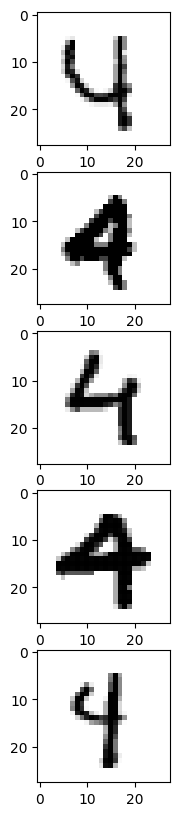

In [8]:
def Q5():

    ### STUDENT START ###

    # Train a 1-Nearest Neighbor model
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(mini_train_data, mini_train_labels)

    # Evaluate the model on the dev set
    dev_predictions = knn.predict(dev_data)

    # Calculate and display the confusion matrix
    cm = confusion_matrix(dev_labels, dev_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Find the most confused digits
    most_confused_digit_pair = np.unravel_index(np.argmax(cm - np.diag(np.diag(cm))), cm.shape)
    most_confused_digit = (most_confused_digit_pair[0], most_confused_digit_pair[1])
    print(f"The model most often confuses digit {most_confused_digit[0]} as digit {most_confused_digit[1]}.")

    # Show examples of misclassified digits

    # Set black and white colormap
    plt.rc('image', cmap='binary')

    # Load MNIST dataset
    images = train_data.values
    labels = train_labels.values
    images = dev_data[(dev_labels == '4') & (dev_predictions == '9')].values
    labels = dev_labels[(dev_labels == '4') & (dev_predictions == '9')].values
    images[1]

    # Function to reshape image from 1D to 2D (28x28 pixels)
    def reshape_image(image):
      return image.reshape(28, 28)

    # Create figure for plotting
    fig, axes = plt.subplots(5, 1, figsize=(10, 10))

    # Plot each digit example
    for i in range(5):
      image = reshape_image(images[i])
      axes[i].imshow(image)

    ### STUDENT END ###

Q5()

Answer to Question 5: The model most often confuses digit 4 as digit 9.


### Resources Used

- Scikit-learn Documentation
- NumPy Documentation
- Stack Overflow
- Google Gemini
- OpenAI Chat GPT